# Assignment 2 - Codebook 2
Emma McCready\
sba23001

---

# Analysis of Ireland's Transport Data

See other codebook for project background/planning and dataset sources.

In [1]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore') 

#STATS
import scipy as scipy
from scipy import stats
from scipy.stats import shapiro
from statsmodels.formula.api import ols
import statsmodels.api as sm

#ML
from sklearn import preprocessing
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error,explained_variance_score, 
                             classification_report, confusion_matrix)
from sklearn.model_selection import (GridSearchCV, cross_val_score, cross_val_predict, 
                                     StratifiedKFold, learning_curve, train_test_split)
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.svm import SVR

# Data I'm focusing further analysis on:


These datasets were explored visually in Section 6 of Codebook 1.



---

# Section 1. Statistical Analysis

First, I'll load the OECD dataset looking at the number of passengers travelling per kilometer in millions, and then prepare it. I won't limit the data to the EU14 like I did in Codebook 1, in the interest of having a larger dataset for analysis.
I didn't look at the missing values previously as I only worked with a subset of the data, so I will look at this now also. 

In preparing the datasets, I will load them in and clean them using the same method as in Codebook 1. Next I will merge them, and then look at missing values. Originally I looked and dealt with missing values in the individual datasets first, but I have since edited my code as to merge them and then deal with missing values is a better approach with less code involved. Therefore, the codebook is more interpretable and efficient.

In [2]:
df3 = pd.read_csv("oecd_IE_v_EU_passenger_transport.csv")
df3 = df3.drop(columns = ['SUBJECT', 'FREQUENCY', 'Flag Codes'])
df3 = df3.rename(columns = {'INDICATOR':'Statistic Label','MEASURE':'UNIT','TIME':'Year'})
#df3.info()

df4 = pd.read_csv("oecd_IE_v_EU_infra_spending.csv")
df4['Value'] = df4['Value'].apply(lambda x: int(x) // 1000000 if not pd.isna(x) else x) #removing sci notation&dividing by million to maximise data-ink ratio)
df4 = df4.drop(columns=['SUBJECT', 'FREQUENCY', 'Flag Codes'])
df4 = df4.rename(columns={'INDICATOR':'Statistic Label','MEASURE':'UNIT','TIME':'Year'}) 

df4['UNIT'] = 'EUR in MILLIONS' # to better reflect what the unit of the value is

#df4.info()

Originally, I used pd.merge() for an inner merge on year and country column ('LOCATION'), as I'm interested in the relationship between the passenger count and infrastructure spending, so I only want instances where there's data available for both. However, I had issues then trying to reshape the dataframe. I tried to do by melting it (melting turns columns into rows, i.e. unpivoting from wide format to long). After some troubleshooting and googling, I realised I should've been using [pd.concat()](https://pandas.pydata.org/docs/reference/api/pandas.concat.html), which is much tidier.

In [3]:
df_merged = pd.concat([df3, df4], ignore_index=True)

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1988 entries, 0 to 1987
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   LOCATION         1988 non-null   object 
 1   Statistic Label  1988 non-null   object 
 2   UNIT             1988 non-null   object 
 3   Year             1988 non-null   int64  
 4   Value            1911 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 77.8+ KB


#### Looking at missing values...

I will first see how many missing values there are, and then isolate them so I can figure out why they are missing, and then deal with them, likely by dropping them. I'm particularly interested in using `.describe(include=object)` on the 'geo' column as this is a label for the data, to see how many unique values there are. This will help me decide how to handle missing values.

In [4]:
missing_count = df_merged['Value'].isnull().sum()

print('There are', missing_count, 'missing values. The total percentage of missing values is', 
      round((missing_count/len(df_merged) * 100), 2), '%')

There are 77 missing values. The total percentage of missing values is 3.87 %


In [5]:
missing = pd.isnull(df_merged['Value'])
missing_data = df_merged[missing]
missing_data.describe(include=object)

,LOCATION,Statistic Label,UNIT
count,77,77,77
unique,1,2,2
top,MLT,PASSTRANSP,MLN_PKM
freq,77,50,50


Inspection of the missing data reveals that there is no data at all for only 1 unique LOCATION value which is Malta, presumably because there's no rail system there, so I'll just drop Malta from the dataset, as it's providing no benefit in the dataset. therefore, the data was Missing Not At Random (MNAR).

In [6]:
df_merged = df_merged.drop(df_merged[df_merged['LOCATION'] == 'MLT'].index)
#df_merged.info()

My dataset is now ready for analysis. I'll first pivot it on the Statistical Label so that I can get statistical information from it. 

In [7]:
df_pivot = pd.pivot_table(df_merged, index=['LOCATION','Year'], columns='Statistic Label', values='Value').reset_index()
df_pivot = df_pivot.rename_axis(None, axis=1) # because the index solumn was named 'Statistic Label' after pivoting
df_pivot.head()

,LOCATION,Year,INFRAINVEST,PASSTRANSP
0,AUT,1970,NaN,6281.0
1,AUT,1971,NaN,6506.0
2,AUT,1972,NaN,6569.0
3,AUT,1973,NaN,6513.0
4,AUT,1974,NaN,6575.0


In [8]:
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1270 entries, 0 to 1269
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LOCATION     1270 non-null   object 
 1   Year         1270 non-null   int64  
 2   INFRAINVEST  641 non-null    float64
 3   PASSTRANSP   1270 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 39.8+ KB


In [9]:
df_pivot.dropna().describe()

,Year,INFRAINVEST,PASSTRANSP
count,641.000000,641.000000,641.000000
mean,2007.923557,1215.113885,14484.746479
std,7.586713,2144.512269,24317.270337
min,1995.000000,0.000000,178.000000
25%,2001.000000,96.000000,1252.000000
50%,2008.000000,316.000000,5149.000000
75%,2014.000000,1137.000000,12208.000000
max,2021.000000,11557.000000,112309.000000


In the pivoted dataset, there two columns, each representing the values in the original datasets.  
`INFRAINVEST` refers to the amount of money invested into rail infrastructure in a country for a given year, measured in millions of Euro.
`PASSTRANSP` refers to the amount of passengers transported a kilometre in millions.

from using describe(), the following information: 

* Re: `INFRAINVEST`:
    * The mean annual investment into rail infrastructure by EU countries is €1,215,113,885, and the median amount invested is €316,000,000
        * The large difference between the mean and median implies that the distribution of investments is affected by outliers. As the mean is bigger than the median, the data is right-skewed.
    * The most a country has invested into infrastructure in a year is €11,557,000,000
    * The standard deviation is €2,144.512269, 
        * This is quite high, meaning there's likely spread or a lot of variation in countries' infrastructure spending. This is not surprising due to the difference in wealth of different EU countries. The difference between 25th percentile (Q1) and 75th percentile (Q3) confirms this.
    
* Re: `PASSTRANSP`:
    * The mean number of passengers travelling per kilometer annually in a given country is 13,780,826,129, and the median is 5,739,500,000.
        * Again the mean is signifiantly higher than the median, implying a right-skewed data and outliers.
    * The most amount of passengers in a country travelling per kilometer is 117,852,000,000 in a year.
    * The standard deviation is 20,905,264,738 passengers. 
        * This once again indicates a large spread or variability in the data. Again this isn't surprising, as wealthier countries might have a larger rail infrastructure, and larger countries may have more need of a larger rail system.
        
To look at the data, I'll visualise the data using a histogram and box plot. I will look at the data as a whole, and not focus on individual countries, as there are too many. This will help me get a better understanding of what the data looks like for each variable

<Figure size 640x480 with 0 Axes>

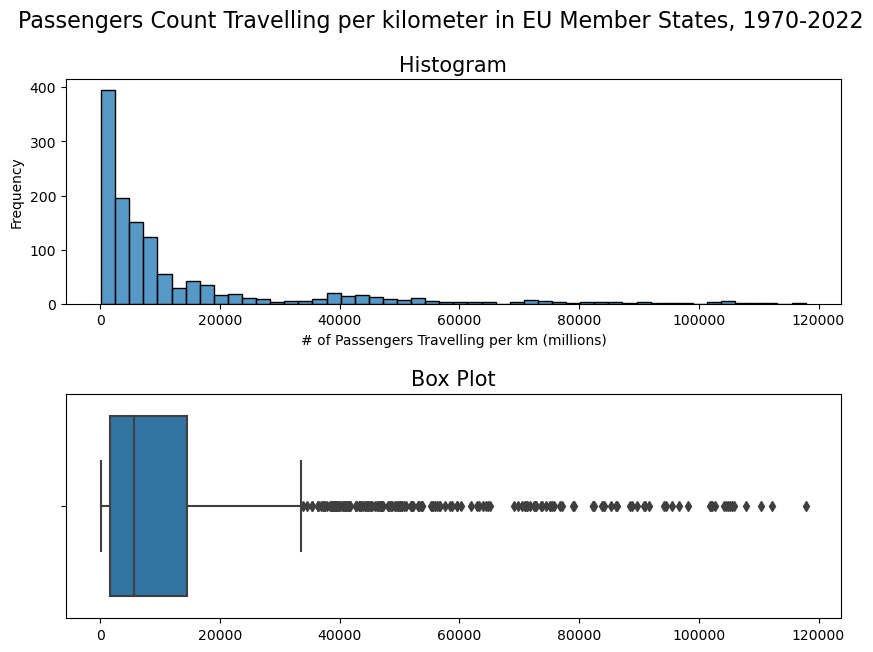

In [10]:
plt.subplots_adjust(hspace=0.4)
plt.figure(figsize=(10, 7))
plt.suptitle('Passengers Count Travelling per kilometer in EU Member States, 1970-2022', fontsize=16) 
# main title means I don't need long titles for individual plots

plt.subplot(2, 1, 1)
sns.histplot(df_pivot['PASSTRANSP'], kde=False)
plt.xlabel('# of Passengers Travelling per km (millions)')
plt.ylabel('Frequency')
plt.title('Histogram', fontsize=15)

plt.subplot(2, 1, 2)
sns.boxplot(x='PASSTRANSP', data=df_pivot) # horizontal because it's easier to interpret
plt.xlabel('')  # label redundant bc i've titled the plot
plt.title('Box Plot', fontsize=15)

plt.subplots_adjust(hspace=0.4)
plt.show()

<Figure size 640x480 with 0 Axes>

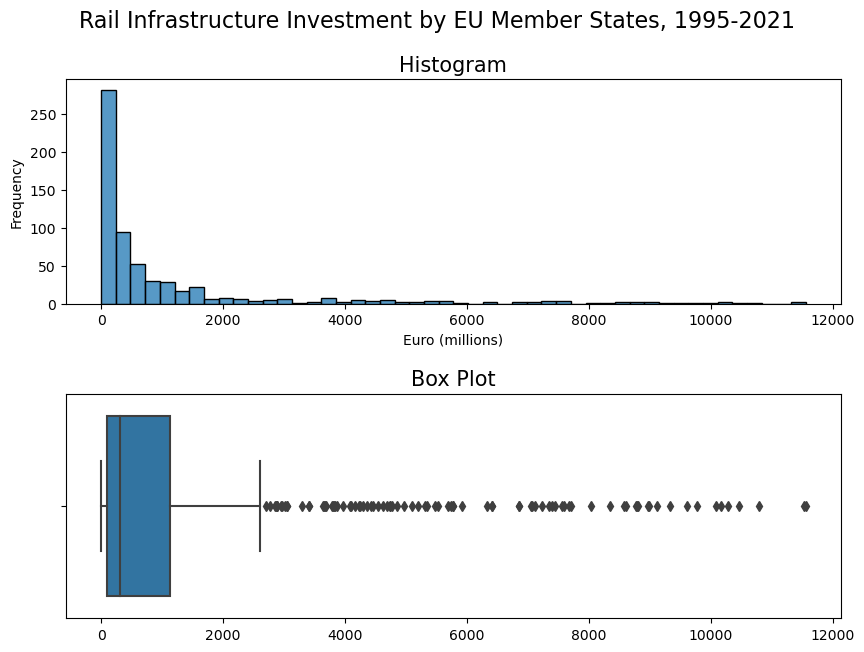

In [11]:
plt.subplots_adjust(hspace=0.4)
plt.figure(figsize=(10, 7))
plt.suptitle('Rail Infrastructure Investment by EU Member States, 1995-2021 ', fontsize=16) 

plt.subplot(2, 1, 1)
sns.histplot(df_pivot['INFRAINVEST'], kde=False)
plt.xlabel('Euro (millions)')
plt.ylabel('Frequency')
plt.title('Histogram', fontsize=15)

plt.subplot(2, 1, 2)
sns.boxplot(x='INFRAINVEST', data=df_pivot)
plt.xlabel('') 
plt.title('Box Plot', fontsize=15)

plt.subplots_adjust(hspace=0.4)
plt.show()

These two Histograms confirm that the data is very right-skewed in both instances. Similarly, the box plot confirms that there is both a large spread and many outliers in both cases.

#### 2.2 Data Preparation: Transforming/Normalising

Given how skewed by data is, So i will first log transform to normalise it. Once it's normalised, I can apply statistical techniques that assume normality. Log transforming will also help with the variance. 
* However, the variable [INFRAINVEST] contains some 0 values, which are non compatible. I will add a constant to my data in this case.
Next I need to look at the normality of my data. To do this I'll create Q-Q plots for both of the variables. 
Q-Q plots are used to find the type of distribution for a random variable.
ref: [Medium Article:](https://medium.com/preai/q-q-plots-explained-75f5bc6d68be)

<Figure size 640x480 with 0 Axes>

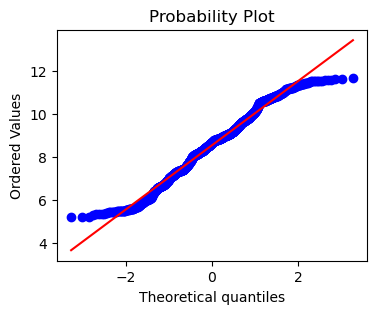

<Figure size 640x480 with 0 Axes>

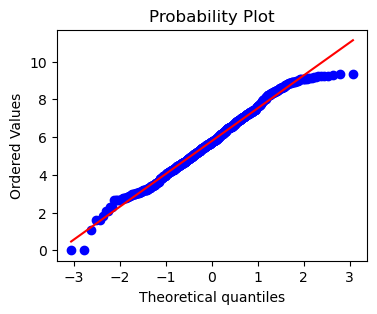

<Figure size 640x480 with 0 Axes>

In [12]:
df_pivot['log_INFRAINVEST'] = np.log1p(df_pivot['INFRAINVEST'] + 0.001) # adding a small constant to handle zero values
df_pivot['log_PASSTRANSP'] = np.log1p(df_pivot['PASSTRANSP'] + 0.001) # for consistency 

plt.figure(figsize=(4, 3)) # it was very big before
stats.probplot(df_pivot['log_PASSTRANSP'], plot = plt)
plt.figure()

plt.figure(figsize=(4, 3))
stats.probplot(df_pivot['log_INFRAINVEST'].dropna(), plot = plt) # had to drop missing values
plt.figure()

To confirm normality for both features, I'll use the Shapiro-Wilk test.
* H0: data comes from normal distribution
* H1: data does not come from normal distribution

In [13]:
columns_to_test = ['log_INFRAINVEST', 'log_PASSTRANSP']

for column in columns_to_test:
    stat, p_value = shapiro(df_pivot[column].dropna())
    print(f'Shapiro-Wilk test for {column}: Statistic={stat:.4f}, p-value={p_value:.4f}')   

Shapiro-Wilk test for log_INFRAINVEST: Statistic=0.9898, p-value=0.0002
Shapiro-Wilk test for log_PASSTRANSP: Statistic=0.9844, p-value=0.0000


As p-value is less than alpha, we reject the null hypothesis that the log transformed data comes from a normally distributed population. Thus, no parametric tests should be performed on this data in its current form.

I tried many methods of transforming data, includinglog transforming, and googled more options (I triedusing boxcox from scipy.stats and also ranking, but none worked). Although this [article](https://medium.com/analytics-vidhya/a-guide-to-data-transformation-9e5fa9ae1ca3#:~:text=Normalization%20is%20the%20process%20of,a%20standard%20deviation%20of%201) is for R, I found it useful when figuring out ways of normalising. I deleted most coding cells containing attempts as it made this codebook messy.

**As I couldn't normalise my data, I won't be able to apply any parametric inferential statistical techniques in the dataset's current form.**
* in codebook 1, I ignored the best performing countries (Germany, Italy, Spain and France) and compared the remaining EU countries. In a statistical analysis however, this could introduce bias.
* I could try to remove some outliers that are causing the issue, but I don't feel comfortable losing any potential valuable information that they may contain. [Identifying and removing outliers](https://medium.com/data-and-beyond/outlier-detection-and-handling-with-python-techniques-and-examples-3094778ef4e)

In [14]:
df_pivot.shape # to have this handy for reference

(1270, 6)

In [15]:
from scipy.stats import zscore

z_scores1 = zscore(df_pivot['PASSTRANSP']) # doing this on 
z_scores2 = zscore(df_pivot['INFRAINVEST'].dropna())

threshold = 2.5 # moderate threshold

# Identify outliers based on the threshold
outliers1 = (np.abs(z_scores1) > threshold)
outliers2 = (np.abs(z_scores2) > threshold)

# Remove outliers from the DataFrame
df_outlier_free = df_pivot[~(outliers1|outliers2)]
df_outlier_free.shape

(1199, 6)

<Figure size 640x480 with 0 Axes>

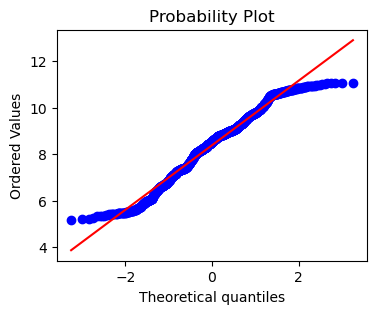

<Figure size 640x480 with 0 Axes>

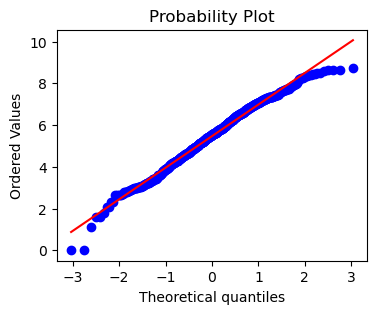

<Figure size 640x480 with 0 Axes>

In [16]:
df_outlier_free['log_INFRAINVEST'] = np.log1p(df_outlier_free['INFRAINVEST'] + 0.001) # adding a small constant to handle zero values
df_outlier_free['log_PASSTRANSP'] = np.log1p(df_outlier_free['PASSTRANSP'] + 0.001) # for consistency 

plt.figure(figsize=(4, 3))
stats.probplot(df_outlier_free['log_PASSTRANSP'], plot = plt)
plt.figure()

plt.figure(figsize=(4, 3))
stats.probplot(df_outlier_free['log_INFRAINVEST'].dropna(), plot = plt) # had to drop missing values
plt.figure()

In [17]:
columns_to_test = ['log_INFRAINVEST', 'log_PASSTRANSP']

for column in columns_to_test:
    stat, p_value = shapiro(df_outlier_free[column].dropna())
    print(f'Shapiro-Wilk test for {column}: Statistic={stat:.4f}, p-value={p_value:.4f}')   

Shapiro-Wilk test for log_INFRAINVEST: Statistic=0.9896, p-value=0.0004
Shapiro-Wilk test for log_PASSTRANSP: Statistic=0.9793, p-value=0.0000


##### This was a also unsuccessful, so I'll have to try to remove the countries that I did in Codebook 1, which will hopefully help.

In [18]:
exclude_locations = ['DEU', 'FRA', 'ITA', 'ESP']
df_pivot_revised = df_pivot[~df_pivot['LOCATION'].isin(exclude_locations)].reset_index(drop=True)

#df_pivot_revised.LOCATION.unique() # to confirm

Shapiro-Wilk test for log_INFRAINVEST: Statistic=0.9744, p-value=0.0000
Shapiro-Wilk test for log_PASSTRANSP: Statistic=0.9751, p-value=0.0000


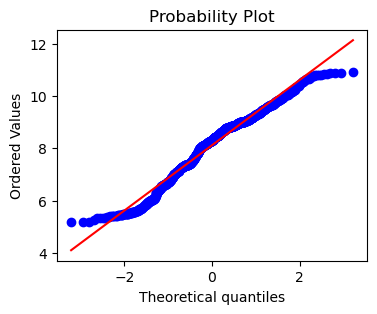

<Figure size 640x480 with 0 Axes>

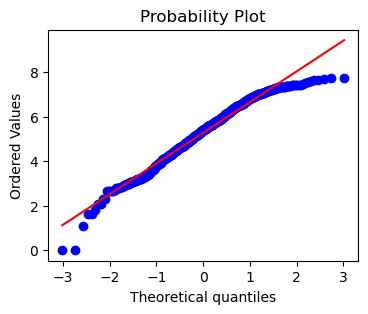

<Figure size 640x480 with 0 Axes>

In [19]:
df_pivot_revised['log_INFRAINVEST'] = np.log1p(df_pivot_revised['INFRAINVEST'] + 0.001) # adding a small constant to handle zero values
df_pivot_revised['log_PASSTRANSP'] = np.log1p(df_pivot_revised['PASSTRANSP'] + 0.001) # for consistency 

plt.figure(figsize=(4, 3)) # it was very big before
stats.probplot(df_pivot_revised['log_PASSTRANSP'], plot = plt)
plt.figure()

plt.figure(figsize=(4, 3))
stats.probplot(df_pivot_revised['log_INFRAINVEST'].dropna(), plot = plt) # had to drop missing values
plt.figure()

columns_to_test = ['log_INFRAINVEST', 'log_PASSTRANSP']

for column in columns_to_test:
    stat, p_value = shapiro(df_pivot_revised[column].dropna())
    print(f'Shapiro-Wilk test for {column}: Statistic={stat:.4f}, p-value={p_value:.4f}')   

This unfortunately didn't help to normalise the data either. The last thing I'll try is limit the years of the dataset from 1996 (when the data started being collected) to 2019. I know from visualising the data in Codebook 1 that there were massive drops caused by the pandemic in 2020 re: passenger numbers. This will also mean there's no missing values from `INFRAINVEST`.

Shapiro-Wilk test for log_INFRAINVEST: Statistic=0.9803, p-value=0.0000
Shapiro-Wilk test for log_PASSTRANSP: Statistic=0.9753, p-value=0.0000


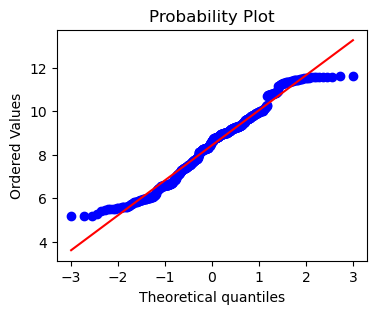

<Figure size 640x480 with 0 Axes>

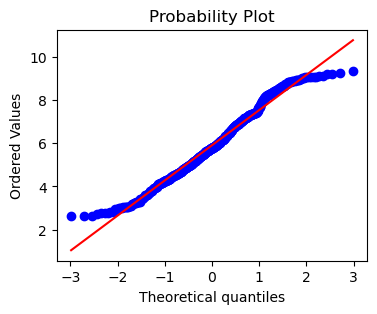

<Figure size 640x480 with 0 Axes>

In [20]:
df_years_revised = df_pivot[(df_pivot['Year'] >= 2000) & (df_pivot['Year'] <= 2019)]

df_years_revised['log_INFRAINVEST'] = np.log1p(df_years_revised['INFRAINVEST'] + 0.001) # adding a small constant to handle zero values
df_years_revised['log_PASSTRANSP'] = np.log1p(df_years_revised['PASSTRANSP'] + 0.001) # for consistency 

plt.figure(figsize=(4, 3))
stats.probplot(df_years_revised['log_PASSTRANSP'], plot = plt)
plt.figure()

plt.figure(figsize=(4, 3))
stats.probplot(df_years_revised['log_INFRAINVEST'].dropna(), plot = plt) 
plt.figure()

columns_to_test = ['log_INFRAINVEST', 'log_PASSTRANSP']
for column in columns_to_test:
    stat, p_value = shapiro(df_years_revised[column].dropna())
    print(f'Shapiro-Wilk test for {column}: Statistic={stat:.4f}, p-value={p_value:.4f}')   

#### This again was unsuccessful, so I'll have to use non-parametric tests. 

Out of interest, I will try one parametric test though.

### 2.3 Linear Regression

Using my two variables, I will test my hypothesis that there is a linear relationship between the number of passengers transported per kilometer ('PASSTRANSP') and infrastructure investment ('INFRAINVEST') in Ireland compared to all other EU Member States, over the period 1996 to 2019. I chose these years for the same reasons as above. 

I'll start by redefining my pivot, to start fresh with a new dataframe. To deal with missing values, I'll drop them, as there should be enough data remaining in the dataset that this shouldn't have too much of an impact. I did check, and there's approc 21 missing values.

In [21]:
df_pivot = pd.pivot_table(df_merged, index=['LOCATION','Year'], columns='Statistic Label', values='Value').reset_index()
df_pivot = df_pivot.rename_axis(None, axis=1) 
df_regression = df_pivot[(df_pivot['Year'] >= 1996) & (df_pivot['Year'] <= 2019)]
df_regression = df_regression.dropna()
#df_regression.info()

Now I'll creathe the model. 
* Step 1 is to prepare my X variable, which is 'INFRAINVEST'. I need to isolate Irish data first. I had to use one-hot encoding to isolate the Irish data. 
    * I could multiply after onehot encoding as it assigns either a 0 or 1 if it's ireland or not. So I could multiply INFRAINVEST by the dummy column, as only multiplying by 1 gives a value, this isolating irish data.
* Step 2 is just to prepare the y variable (target variable), which is 'PASSTRANSP'
* Step 3 is to initialise and fit the linear regression model
* Step 4 use the model to predict, and then to plot it



Intercept: 2884.6531709909086
Coefficients: [ 10.07224783 -11.63505414]


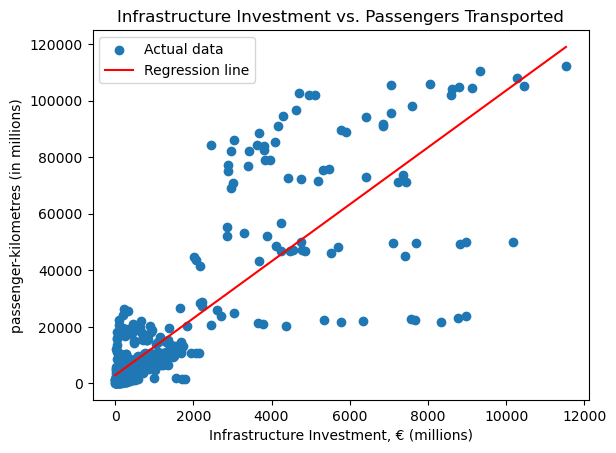

In [22]:
from sklearn.linear_model import LinearRegression
lrm = LinearRegression()

# Step 1
df_regression['IRL'] = pd.get_dummies(df_regression['LOCATION'])['IRL']
df_regression['INFRAINVEST_IRL'] = df_regression['INFRAINVEST'] * df_regression['IRL'] # see above
X = df_regression[['INFRAINVEST', 'INFRAINVEST_IRL']] 

# Step 2
y = df_regression['PASSTRANSP']

# Step 3
lrm = LinearRegression()
lrm.fit(X, y)

print("Intercept:", lrm.intercept_)
print("Coefficients:", lrm.coef_)


# Step 4
plt.scatter(df_regression['INFRAINVEST'], df_regression['PASSTRANSP'], label='Actual data')

x_range = np.linspace(df_regression['INFRAINVEST'].min(), df_regression['INFRAINVEST'].max(), 1000).reshape(-1, 1)
# ^^ this is to set a range of values, using INFRAINVEST min and max, evenly spaced over 1000 data points

y_pred = lrm.predict(np.hstack((x_range, np.zeros_like(x_range)))) # making a prediction using the trained model

plt.plot(x_range, y_pred, color='red', label='Regression line')
plt.xlabel('Infrastructure Investment, € (millions)')
plt.ylabel('passenger-kilometres (in millions)')
plt.title('Infrastructure Investment vs. Passengers Transported')
plt.legend()
plt.show()

In [25]:
y_pred = lrm.predict(X)
r2 = r2_score(y, y_pred)
print("R-squared:", r2)

rmse1 = rmse(y, y_pred)
print("Mean Squared Error:", rmse1)

R-squared: 0.7044787022080121
Mean Squared Error: 13447.64754347911


From looking at the graph, i see there's decent correlation at lower investment values, however as investment increases the data points are a lot more dispersed and there are a lot of outliers.
By calculating the R^2 value, I get 0.70, which is decent but not great correlation. Given the issues I had previously, I also calculated RMSE, which measures the difference between the predicted and actual values. The lower the better, and this is a decent value when compared to the scale of the target variable. *However, given the issues with normalising the dataset previously, I wouldn't trust this model*

### 2.4 Non-parametric tests

where I went for more info: [ref1](https://medium.com/@ketanmahandule2001/non-parametric-statistics-7a9a9cab5efc) [ref2](https://medium.com/analytics-vidhya/basic-introduction-to-non-parametric-tests-997414d303ae)

##### 2.4.1 Kruskal-Wallis Test

Variable: 'INFRAINVEST'

Hypothesis: Is there a significant difference in the amound invested into rail infrastructure among Ireland and all other EU Member States?
* H0: there is no difference in infrastructure investment among Ireland and all other EU Member States
* H1: there is a statistical difference in infrastructure investment among Ireland and all other EU Member States

In [33]:
from scipy.stats import kruskal

#creating my datasets but first getting rid of missing values
df_pivot_no_missing = df_pivot.dropna()
kw_test_ire = df_pivot_no_missing[df_pivot_no_missing['LOCATION'] == 'IRL']['INFRAINVEST']
kw_test_other_countries = df_pivot_no_missing[df_pivot_no_missing['LOCATION'] != 'IRL']['INFRAINVEST']

#running the test
stat, p= kruskal(kw_test_ire,kw_test_other_countries)

print('Statistical Test:', stat)
print("p-value:", p)

Statistical Test: 18.890914692846774
p-value: 1.3841028850583238e-05


as the p-value < 0.05 (alpha), the H0 is rejected, and it is concluded that there is a statistical difference in the distribution of infrastructure investment among Ireland and all other EU Member States. This is not surprising, given the visualisations of this dataset in Codebook 1. 

##### 2.4.2 UMann-Whitney Test

This time, I will look to see if there's a statistical difference in passenger numbers between Ireland and Denmark, which are two relatively similar countries. In terms of population, Denmark is more populous (5,903,000 vs 5,127,000) but Ireland is approximately 1.6x bigger than Denmark, so in theory it should have  people travelling longer distances.

Variable: 'PASSTRANSP'

I'll use the original full dataset to include passenger numbers for all year, as a larger dataset should improve accuracy.

Hypothesis:  Is there a significant difference in the number of passengers transported per kilometer among Ireland and Denmark?
* H0: there is no difference in the number of passengers transported per kilometer among Ireland and Denmark
* H1: there is statistical a difference in the number of passengers transported per kilometer among Ireland and Denmark

In [50]:
from scipy.stats import mannwhitneyu

um_test_ire = df_pivot[df_pivot['LOCATION'] == 'IRL']['PASSTRANSP'].dropna()
um_test_dnk = df_pivot[df_pivot['LOCATION'] == 'DNK']['PASSTRANSP'].dropna()

stat, p = mannwhitneyu(um_test_ire, um_test_dnk)
print('Statistical Test:', stat)
print("p-value:", p)


Statistical Test: 0.0
p-value: 3.502958715890672e-18


As the p-value < 0.05 (alpha), the H0 is rejected, and it is concluded that there is a statistical difference in the number of passengers transported per kilometer among Ireland and Denmark. Inspection of the data shows Denmark has a much higher amount of passengers travelling per kilometer, implying they have a larger, more popular rail system than Ireland.

##### 2.4.3 Spearman's Rank Correlation

I will continue looking at Ireland vs Denmark, as the dataset in its entirety is too varied for a meaningful analysis.

Hypothesis:  Is there a correlation between the number of passengers transported per kilometer and infrastructure investment in Ireland compared to Denmark?
* H0: no correlation between the number of passengers transported per kilometer and infrastructure investment in Ireland compared to Denmark
* H1: there is scorrelation between the number of passengers transported per kilometer and infrastructure investment in Ireland compared to Denmark



In [57]:
from scipy.stats import spearmanr

sr_test_ire = df_pivot[df_pivot['LOCATION'] == 'IRL'][['PASSTRANSP', 'INFRAINVEST']].dropna()
sr_test_dnk = df_pivot[df_pivot['LOCATION'] == 'DNK'][['PASSTRANSP', 'INFRAINVEST']].dropna()

correlation_coefficient, p_value_ire = spearmanr(sr_test_ire['PASSTRANSP'], sr_test_ire['INFRAINVEST']) # irish analysis
correlation_coefficient_dnk, p_value_dnk = spearmanr(sr_test_dnk['PASSTRANSP'], sr_test_dnk['INFRAINVEST']) # danish analysis

print('\nFor Ireland:')
print('Correlation Coefficient:', correlation_coefficient)
print('P-value:', p_value)

print('\nFor Denmark:')
print('Correlation Coefficient:', correlation_coefficient_dnk)
print('P-value:', p_value_dnk)


For Ireland:
Correlation Coefficient: 0.2718413443731023
P-value: 0.17913783301861796

For Denmark:
Correlation Coefficient: 0.31789520212249184
P-value: 0.13007442963096122


In both cases, there's a positive correlation coefficient, implying that as investment in rail infrastructure increases, so does the number of passengers being transported. However, neither of the p-values > alpha, meaning thaat the relationship between these variables aren't statistically significant.

##### 2.4.4 Wilcoxon Signed-Rank Test

As I have the passenger transport information from before and after covid when I know there was a substantial drop from visualising my data in Codebook 1, I could use this test to take two reference years (i.e. 2019 and 2022) to determine  if there is a significant difference in passenger transport between these two time points.

* H0: no significant difference in passenger transport before and after pandemic
* H1: significant difference in passenger transport before and after pandemic


In [71]:
from scipy.stats import wilcoxon

ire = df_pivot[df_pivot['LOCATION'] == 'IRL']

ire_before = ire[ire['Year'] == 2019] #defining reference eyars
ire_after = ire[ire['Year']==2022]

stat, p_value = wilcoxon(ire_before['PASSTRANSP'], ire_after['PASSTRANSP'])
print('Wilcoxon Signed-Rank Test Statistic:', stat)
print('P-value:', p_value)


Wilcoxon Signed-Rank Test Statistic: 0.0
P-value: 1.0


p-value > alpha, meaning the H1 is rejected and the H0 is accepted. This means there is not enough evidence to conclude a significant difference in the number of passengers transported per kilometer in Ireland before and after the pandemic. This could be down to more people returning to the office after the pandemic.

However, this test assumes that the data comes from a symmetric distribution. After plotting a histogram, I found that the data for Ireland is slightly skewed, albeit less skewed than the overall dataset. The results of this test are not fully reliable. 

---

# 2. Machine Learning
---

# EUROSTAT data

I decided to build a dataset using the EUROSTAT database to check if there's any correlation between different features, related and unrelated to rail transport. I chose the EUROSTAT database as there's more datasets included. However, the OECD data on amount of passenger transported per kilometre in millions (used in Section 1) goes back further years, so it was more suitable for that analysis.

The datasets I looked for were the following: 
* At-risk-of-poverty rate of EU Member States over time
* Different measurements for the average rating of satisfaction by domain, sex, age and educational attainment level
    * I downloaded these separately to allow the data to merge better. This serves an additional purpose to reduce demand on computer resources.
* Tourism related - Nights spent at tourist accommodation establishments
* Rail transport-related:
    * Passenger train traffic performance by type of train speed
    * passengers transported_PKM
    * passengers transported_Total
    * Railway accidents 
    * railway length

---
***Legend***

**The Columns in this dataset were named based on their survey codes in the EUROSTAT database.**

* ILC_LI02 | [At-risk-of-poverty rate by poverty threshold, age and sex - EU-SILC and ECHP surveys](https://ec.europa.eu/eurostat/databrowser/view/ILC_LI02/default/table?lang=en)
* ILC_PW01 | [Average rating of satisfaction by domain, sex, age and educational attainment level](https://ec.europa.eu/eurostat/databrowser/view/ILC_PW01/default/table?lang=en)
    * *Within this, 10 different subsets of this dataset were used:*
        * ILC_PW01 | ACCSAT | Satisfaction with accommodation
        * ILC_PW01_2 | COMSAT | Satisfaction with commuting time
        * ILC_PW01_3 | FINSAT | Satisfaction with financial situation
        * ILC_PW01_4 | GREENSAT | Satisfaction with recreational and green areas
        * ILC_PW01_5 | JOBSAT | Job satisfaction
        * ILC_PW01_6 | LIFESAT | Overall life satisfaction
        * ILC_PW01_7 | LIVENVSAT | Satisfaction with living environment
        * ILC_PW01_8 | MEANLIFE | Meaning of life
        * ILC_PW01_9 | RELSAT | Satisfaction with personal relationships
        * ILC_PW01_10 | TIMSAT | Satisfaction with time use
* TOUR_OCC_NINATS | [Nights spent at hotels and similar accommodation (NACE Rev.2 activity I55.1) by size class](https://ec.europa.eu/eurostat/databrowser/product/page/tour_occ_ninats)
* RAIL_TF_PASSMOV | [Passenger train traffic performance by type of train speed](https://ec.europa.eu/eurostat/databrowser/view/RAIL_TF_PASSMOV/default/table?lang=en&category=rail.rail_tf)
* RAIL_PA_TOTAL | [Passengers transported](https://ec.europa.eu/eurostat/databrowser/product/view/rail_pa_total) 
    * *Within this, 2 different subsets of this dataset were used:*
        * RAIL_PA_TOTAL | Passengers transported measured in millions of passenger-kilometres
        * RAIL_PA_TOTAL_14 | Passengers transported measured in thousand passengers
* RAIL_AC_CATNMBR | [Railway accidents by type of accident - annual data (2004-2015)](https://ec.europa.eu/eurostat/databrowser/view/rail_ac_catnmbr/default/table?lang=en)
* TTR00003 | [Total length of railway lines](https://ec.europa.eu/eurostat/databrowser/view/TTR00003/default/bar?lang=en)




---

because there's so many files, I decided to load them in with [GLOB](https://builtin.com/software-engineering-perspectives/glob-in-python) so I could combine them into one dataset. 

When downloading this data from the [EUROSTAT Database](https://ec.europa.eu/eurostat/web/main/data/database), I downloaded data for only the 27 EU Member States, and downloaded data for as many years as was available. 
I used an outer merge for this to preserve all rows from all dataframes, which results in 'NaN' for non-matching values. This is useful to keep all rows from both DataFrames and fill in missing values where there are no matches. I had to opt for this as all of the datasets are of varying length due to different year ranges involved. There as no need for a right or left merge as I have no primary dataset, I want information from each of the datasets merged into one, so an outer is the most appropriate

Originally I tried to load in all datasets and merge them on the two columns I'm interested in, "geo" (the EU Country code) and "TIME_PERIOD" (the year). I also used the "DATAFLOW" to merge on so that it didn't autofill values (I chose "DATAFLOW" as this is the statistical label, and I can pivot on this later when preparing the data). I kept getting a merge error usually caused by overlapping column names in the dataframes that are not specified in the on parameter of the merge function. This was because there were multiple column headings with the same name. Therefore I had to add a suffix parameter in the function, but it still wasn't helping as I was only specifying two suffixes, so I adapted the code accordingly and created a unique suffix for each file. This ended up being doubly beneficial as I could confirm then that all datasets were loaded in.  

**Edit after subsequent analysis:** I couldn't figure out how to structure my dataset properly so I decided to include code here when loading in my datasets to rename the OBS_VALUE columns to the corresponding "DATAFLOW". "DATAFLOW" contains the unique survey code assigned by EUROSTAT, which is unique to and constant in each dataset. This labels the corresponding values a bit more accurately, and I can then drop the "DATAFLOW" column so there's one less column to work with.
I then decided to build in some additional data wrangling into the following codeblock when loading in the data. Notably, three
features (`accident`, `c_resid` and `isced`) contain a series of labels used to refer to observations, plus a "TOTAL" value which is the sum of the other labels. I will focus my on these totals and drop the supplementary labels as they aren't the focus of my analysis.




In [9]:
files = glob.glob('EUROSTAT*.csv')
EUROSTAT_data = pd.DataFrame()  # to store merged data
loaded_files = []  # so the list of files loaded in can be seen in the correct order

for i, f in enumerate(files):
    dataset = pd.read_csv(f) 
    
    obs_columns = [col for col in dataset.columns if col.startswith('OBS_VALUE')]
    dataflow_value = dataset['DATAFLOW'].iloc[0]  # i used 0 just because it's constant in the dataset anyway
    rename_mapping = {obs_column: f'{dataflow_value}_{obs_column.split("_")[-1]}' for obs_column in obs_columns} # so that the output will be "[survey code]_VALUE"
    dataset.rename(columns=rename_mapping, inplace=True)
    
    unit_columns = [col for col in dataset.columns if col.startswith('unit')]
    rename_mapping_unit = {unit_column: f'{dataflow_value}_{unit_column.split("_")[-1]}' for unit_column in unit_columns} # Ijust reused same code here but it's not necessary as there is no _
    dataset.rename(columns=rename_mapping_unit, inplace=True)
    
    filter_cols = ['accident', 'isced11', 'c_resid'] 
    for col in filter_cols:
        if col in dataset.columns:
            dataset = dataset[dataset[col] == 'TOTAL'] # to keep just the total values

    loaded_files.append(f)
    print(f'Loaded file: {f}')

    if EUROSTAT_data.empty:
        EUROSTAT_data = dataset
    else:
        suffixes = ('', f'_{i}')  # to solve merge error issue
        EUROSTAT_data = pd.merge(EUROSTAT_data, dataset, on=['geo', 'TIME_PERIOD'], how='outer', suffixes=suffixes)

#EUROSTAT_data.info()
#EUROSTAT_data.head()

Loaded file: EUROSTAT_At-risk-of-poverty rate by poverty threshold, age and sex_EU-SILC and ECHP surveys.csv
Loaded file: EUROSTAT_Average rating of satisfaction by domain, sex, age and educational attainment level_ACCSAT.csv
Loaded file: EUROSTAT_Average rating of satisfaction by domain, sex, age and educational attainment level_COMSAT.csv
Loaded file: EUROSTAT_Average rating of satisfaction by domain, sex, age and educational attainment level_FINSAT.csv
Loaded file: EUROSTAT_Average rating of satisfaction by domain, sex, age and educational attainment level_GREENSAT.csv
Loaded file: EUROSTAT_Average rating of satisfaction by domain, sex, age and educational attainment level_JOBSAT.csv
Loaded file: EUROSTAT_Average rating of satisfaction by domain, sex, age and educational attainment level_LIFESAT.csv
Loaded file: EUROSTAT_Average rating of satisfaction by domain, sex, age and educational attainment level_LIVENVSAT.csv
Loaded file: EUROSTAT_Average rating of satisfaction by domain, se

All looks good from the above and it looks to have merged okay. As it's a large dataset, I decided to find a quicker way to do EDA, as mentioned [in this article](https://towardsdatascience.com/a-data-scientists-essential-guide-to-exploratory-data-analysis-25637eee0cf6), and used [YData Profiling](https://docs.profiling.ydata.ai/latest/).
The main advantage of this library is that it's very simple to use, and creates a report (Saved also to github, `EUROSTAT_rail_report_preclean.html`). It generates a list of alerts which are a useful guide when performing EDA.

It also has the added benefit of being able to view the first 10 and last 10 rows in the entirety, as to run .head() on a dataset with 153 columns limits the amount of columns you can view.

In [10]:
from ydata_profiling import ProfileReport

profile = ProfileReport(EUROSTAT_data,title="EUROSTAT Rail Data") #generates report

#profile.to_file("EUROSTAT_rail_report_preclean.html") #saves to html

Using this report, I can start to wrangle this dataset now.
* Firstly, some columns only have 1 unique value, meaning it could be worth removing these to make the dataset cleaner and to reduce the demand on resources.
    * Each dataset had a `LAST UPDATE` which seems to just refer to when the dataset was last updatesd. This is irrelevant, and so will be dropped.
    * Similarly, `freq` columns (referring to how often the data is gathered) are irrelevant, as I specifically chose annual data. This will also be dropped.
    * I also specifically targetted either "both sexes" or "all ages" when downloading data, so these columns are also irrelevant as there will be no variance. I have verified that they contain constant values.
    * `indic_il` is the income and living conditions indicator, but is a constant "LI_R_MD60". This is a code used in EUROSTAT to refer to the "At risk of Poverty Rate", and the cut off point of median equivalised income after social transfers is set by detula tot 60%. As this contains no useful info, it will be dropped. 
    * `n_tracks`, `vehicle`,  and `tra_infr` are constants, containing "Total". Again, I targetted totals when downloading datasets. I will remove these as they aren't useful.
    * `nace_r2` is also a constant and contains "I551-I553", which is code in the EUROSTAT database used to refer to "Hotels; holiday and other short-stay accommodation; camping grounds, recreational vehicle parks and trailer parks", which is a total of all of the tourist accommodations. 
    
* Among the Variable types, there are some columns which are "unsupported", so I had a closer look, and they seem to be some of the "OBS_FLAG" variables. They seem to be unsupported because they are 100% missing, but I used the html report to investigate them, They seem to all be constants so I will drop them as they won't be relevant for any analysis.

* "DATAFLOW" contains the Online data code for EUROSTAT. It is useful to preserve this information in the final dataset but I won't bother renaming the columns. I will remove the irreleavnt addition info in these columns ("ESTAT:" and "(1.0)"). The code I will use to remove these from the string is `r'ESTAT:|[(]\d+\.\d+[)]'`. r'ESTAT:|\(0\.1\)' wouldn't remove the (0.1) so I had to take a broader approach. r is there to call the regex library. 
    * `ESTAT:`: removes the string "ESTAT:"
    * `|` logical OR (so both sections of the string removed)
    * `[(]\d+\.\d+[)]`: to remove "(1.0)"
        * `[(]`, `[)]` for the brackets
        * `\d+` for digits (0 to 9)
        * `\.` to remove the dot (.)
    * **EDIT: I ended up using this data to rename the "OBS_VALUE" dataset, so I used the same regex to edit the column names**
        
* "OBS_VALUE" is the value of each dataset. The variable `loaded_files` will give an indication what each value refers to, in order.




In [11]:
columns_to_drop = EUROSTAT_data.columns[EUROSTAT_data.columns.str.startswith('DATAFLOW') | 
                                        EUROSTAT_data.columns.str.startswith('LAST') | 
                                        EUROSTAT_data.columns.str.startswith('freq') |
                                        EUROSTAT_data.columns.str.startswith('OBS_FLAG') | 
                                        EUROSTAT_data.columns.str.startswith('sex') |
                                        EUROSTAT_data.columns.str.startswith('age') |
                                        EUROSTAT_data.columns.str.startswith('indic_il') |
                                        EUROSTAT_data.columns.str.startswith('nace_r2') |
                                        EUROSTAT_data.columns.str.startswith('vehicle') |
                                        EUROSTAT_data.columns.str.startswith('tra_infr') |
                                        EUROSTAT_data.columns.str.startswith('n_tracks') |
                                        EUROSTAT_data.columns.str.startswith('indic_wb') |
                                        EUROSTAT_data.columns.str.startswith('isced11') |
                                        EUROSTAT_data.columns.str.startswith('accident') |
                                        EUROSTAT_data.columns.str.startswith('VALUE') |
                                        EUROSTAT_data.columns.str.startswith('c_resid') |
                                        EUROSTAT_data.columns.str.startswith('hotelsize')
                                       ]

EUROSTAT_clean = EUROSTAT_data.drop(columns=columns_to_drop)

import re #for regex
EUROSTAT_clean.rename(columns=lambda x: re.sub(r'ESTAT:|[(]\d+\.\d+[)]', '', x), inplace=True)
    
#EUROSTAT_clean.describe(include=object)

In [12]:
profile = ProfileReport(EUROSTAT_clean,title="EUROSTAT Rail Data")

#profile.to_file("EUROSTAT_rail_report_clean.html")

In [13]:
EUROSTAT_clean.to_csv('clean_EUROSTAT.csv', index=False, header=True, sep=',')

Interestingly, using the reports generated using YData Profiling, I can actually measure the increase in efficiency in terms of computer resources before and after cleaning.
- **Before cleaning (Initial, before optimising my code when loading in and merging the datasets):** 
    * Total size in memory	5.5 MiB
    * Average record size in memory	408.0 B
- **Before cleaning (Current):** 
    * Total size in memory	1.1 MiB
    * Average record size in memory	1.2 KiB
- **After cleaning:**
    * Total size in memory	275.6 KiB
    * Average record size in memory	296.1 B

This is a decent reduction in computational resource demand - Downloading and loading in the datasets individually helped reduce the length of the dataset, which optimised efficiency on resources massively (memory reduced from 5.5 MiB to 1.1 MiB, and then 275.6 KiB after cleaning).
Cleaning reduced number of columns from 153 to 36.
There are no duplicates which is good.

The trade-off with how I selected and downloaded dataset is that there are a lot of missing values due to how the datasets were merged. I will have to be careful with machine learning and prepare the dataset accordingly. 
I will also probably have to drop the unit columns but right now I'd like them in the dataset for labelling purposes.




From the correlation map, there are some worrying correlations because of the labels which may skew the data so these will have to be dropped for supervised learning.
For machine learning, it's important to have data correctly labelled, so I'll amend that as well. 
* for "TIME_PERIOD", this contains year data, which may be useful for an ML model. 

In [14]:
EUROSTAT_clean['TIME_PERIOD'] = pd.to_datetime(EUROSTAT_clean['TIME_PERIOD'], format='%Y')
EUROSTAT_clean['TIME_PERIOD'] = EUROSTAT_clean['TIME_PERIOD'].dt.year
#EUROSTAT_clean.dtypes

Before I made changes to how I loaded in the data, I was having difficulty pivotting the dataset on the country and year, but couldn't get the OBS_VALUEs to line up, and I also tried using a helper to address the duplicate issues (the error related to duplicate entries for the index-column pairs). 

First I will prepare the dataset

In [31]:
EUROSTAT_clean.rename(columns=lambda x: re.sub(r'.VALUE', '', x), inplace=True) # just for tidiness' sake
EUROSTAT_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   geo               953 non-null    object 
 1   TIME_PERIOD       953 non-null    int32  
 2   ILC_LI02          615 non-null    float64
 3   ILC_PW01          27 non-null     float64
 4   ILC_PW01_2        27 non-null     float64
 5   ILC_PW01_3        54 non-null     float64
 6   ILC_PW01_4        27 non-null     float64
 7   ILC_PW01_5        54 non-null     float64
 8   ILC_PW01_6        108 non-null    float64
 9   ILC_PW01_7        27 non-null     float64
 10  ILC_PW01_8        27 non-null     float64
 11  ILC_PW01_9        54 non-null     float64
 12  ILC_PW01_10       54 non-null     float64
 13  TOUR_OCC_NINATS   295 non-null    float64
 14  RAIL_TF_PASSMOV   783 non-null    float64
 15  RAIL_PA_TOTAL     430 non-null    float64
 16  RAIL_PA_TOTAL_14  431 non-null    float64
 1

### First I will look at correlation:

I started looking at this through the report generated, but would like to create a pairplot. There are too many numerical values (18 columns) though which makes this plot impractical. so instead I'll use a correlation matrix heatmap:

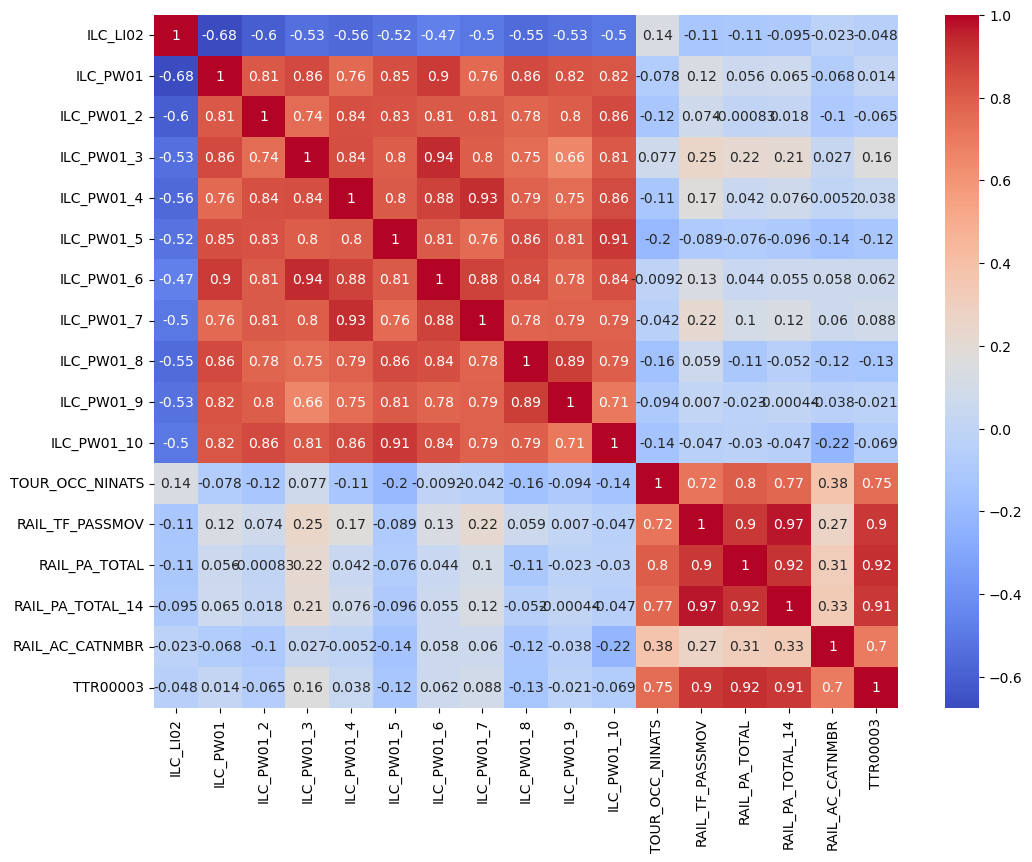

In [16]:
numerical_columns = EUROSTAT_clean.select_dtypes(include='float64').columns
EUROSTAT_numeric = EUROSTAT_clean[numerical_columns]

correlation_matrix = EUROSTAT_numeric.corr()
plt.figure(figsize=(12, 9)) # default was too small
annot_kws = {"size": 8} # default text too big and difficult to read
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

There seems to be decent correlation among the ILC_PWO1 data, which corresponds to average satisfaction rate among member states, so that's expected. These are moderately negatively correlated to the At-risk-of-poverty rate (ILC_LI02) which makes sense.   
The rail datasets and the TOUR_OCC_NINATS dataset, which relates to tourism, seems to be correlated, except for RAIL_AC_CATNMBR which refers to railway accidents.   
Everything else has a weak correlation.

# 2.1 Machine learning: Supervised

My goal is to develop a machine learning model for prediction if the amount of passengers travelling on a train in a given year for a given member state. This is a regression issue as I need to predict a continuous outputs.
* Target feature: `RAIL_PA_TOTAL_14`. 
* This feature refers to the number of passengers in an EU country for a given year, in thousands. 
I will train the model using all of the other features. I'll start by dropping all unit columns as they are irrelevant to any analysis.

I will also use unsupervised learning to assess if there are underlying/hidden relationships between the features in my dataset, using clustering and PCA. If not, then I'll know the target feature can't be predicted accurately using the features I have assembled into the dataset.

In [32]:
filtered_columns = EUROSTAT_clean.filter(like='unit')

EUROSTAT_clean = EUROSTAT_clean.drop(columns=filtered_columns.columns)
EUROSTAT_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   geo               953 non-null    object 
 1   TIME_PERIOD       953 non-null    int32  
 2   ILC_LI02          615 non-null    float64
 3   ILC_PW01          27 non-null     float64
 4   ILC_PW01_2        27 non-null     float64
 5   ILC_PW01_3        54 non-null     float64
 6   ILC_PW01_4        27 non-null     float64
 7   ILC_PW01_5        54 non-null     float64
 8   ILC_PW01_6        108 non-null    float64
 9   ILC_PW01_7        27 non-null     float64
 10  ILC_PW01_8        27 non-null     float64
 11  ILC_PW01_9        54 non-null     float64
 12  ILC_PW01_10       54 non-null     float64
 13  TOUR_OCC_NINATS   295 non-null    float64
 14  RAIL_TF_PASSMOV   783 non-null    float64
 15  RAIL_PA_TOTAL     430 non-null    float64
 16  RAIL_PA_TOTAL_14  431 non-null    float64
 1

######  2.1.1 Pre-processing

The first issue to deal with is deciding what to do with the **missing values**. I would prefer not to drop them completely, as 69.5% of this dataset is NaN according to a YData report. This is simply because some countries may not collect some of this data annually, and also some data refers to surveys which are only conducted once every few years.
* I could try to input missing values using K-nearest neighbors (KNN), but given the high percentage of missing values, this might result in significant bias
* I should try a couple of models which can handle missing values, like Random Forests, Random Forests or Support Vector Machines (SVM)

I have 1 categorical variable ("geo") which will need to be encoded. I'll use OneHotEncoding as I don't want to create an artificial relationship that isn't actually there.

My target variable is RAIL_PA_TOTAL_14, so I will limit the scope of the dataset from 2004 to 2022, as that's when data was available from. 


In [18]:
EUROSTAT_supervised = EUROSTAT_clean[EUROSTAT_clean['TIME_PERIOD'] >= 2004]
EUROSTAT_supervised.info()

<class 'pandas.core.frame.DataFrame'>
Index: 513 entries, 8 to 952
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   geo               513 non-null    object 
 1   TIME_PERIOD       513 non-null    int32  
 2   ILC_LI02          491 non-null    float64
 3   ILC_PW01          27 non-null     float64
 4   ILC_PW01_2        27 non-null     float64
 5   ILC_PW01_3        54 non-null     float64
 6   ILC_PW01_4        27 non-null     float64
 7   ILC_PW01_5        54 non-null     float64
 8   ILC_PW01_6        108 non-null    float64
 9   ILC_PW01_7        27 non-null     float64
 10  ILC_PW01_8        27 non-null     float64
 11  ILC_PW01_9        54 non-null     float64
 12  ILC_PW01_10       54 non-null     float64
 13  TOUR_OCC_NINATS   295 non-null    float64
 14  RAIL_TF_PASSMOV   379 non-null    float64
 15  RAIL_PA_TOTAL     430 non-null    float64
 16  RAIL_PA_TOTAL_14  431 non-null    float64
 17  RA

There are still some missing values, but that's okay. As there should be significantly lower % of missing values now, I could try use K-Nearest Neighbors (KNN) to input the missing values. I'll have to do this as ML models generally can't handle NaN values. I'd prefer KNN to input as I don't feel comfortable doing a simply imputation based on mean or median or any other values. However, KNN imputation does have a larger computational cost. I'll only apply this to the input features (the X data sets), as it's not standard practive to impute missing values in the target variable (y sets).

First, I'll split the data into training and test sets, and also standardise them. I'll use a StandardScalar as it's less sensitive to utliers, and from analysing the YData report, I can see outliers are an issue for some features.

When one-hot encoding, I note it's good practice to use the argument `drop_first=True` to avoid the "dummy variable trap", but I feel the information lost by running this isn't worth it. However I need to note that there could be multicollinearity issues.

In [19]:
EUROSTAT_supervised_dummy = pd.get_dummies(EUROSTAT_supervised, drop_first=True) # only 1 cat feature so wont bother defining. whether or not to use `drop_first=True` TBD

X = EUROSTAT_supervised_dummy.drop(['RAIL_PA_TOTAL_14'], axis=1)
y = EUROSTAT_supervised_dummy['RAIL_PA_TOTAL_14']

y = y.dropna() # had issues w missing values in this set
X = X.loc[y.index] # matching index to align the two datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # random state for reproducibility

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # only need to appy this to input features to help ML algorithm be more efficient
X_test_scaled = scaler.transform(X_test)


knn_imputer = KNNImputer()
X_train_imputed = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(knn_imputer.transform(X_test), columns=X_test.columns)

### Random Forest

In [ ]:
regressor = RandomForestRegressor(random_state = 0)

param_grid = {'max_depth': [1, 10, 100, 150], 'n_estimators': [100, 125, 150]} # extracted for ease of editing, and to keep code tidier
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train_imputed, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

best_model.fit(X_train_imputed, y_train)

y_pred_random = best_model.predict(X_test_imputed)

print(best_params)
print(best_model)

print("R-squared of the model in training set is: {}".format(best_model.score(X_train_imputed, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(best_model.score(X_test_imputed, y_test)))
print("Root mean squared error of the prediction is: {}".format(mse(y_test, y_pred_random)**(1/2)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_pred_random) / y_test)) * 100))

<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i> Comparing results when one-hot encoding if `drop_first=True` is used: </i></summary>  
    
**When used:**  
{'max_depth': 100, 'n_estimators': 10}  
RandomForestRegressor(max_depth=100, n_estimators=10, random_state=0)  
R-squared of the model in training set is: 0.9977331776009687
      
-----Test set statistics-----  
R-squared of the model in test set is: 0.9865264899775867  
Root mean squared error of the prediction is: 62444.612320570304  
Mean absolute percentage error of the prediction is: 13.3018368162640      
    
**When not used:**      
{'max_depth': 10, 'n_estimators': 10}  
RandomForestRegressor(max_depth=10, n_estimators=10, random_state=0)  
R-squared of the model in training set is: 0.9978185807272154  
      
-----Test set statistics-----  
R-squared of the model in test set is: 0.9803444007374025  
Root mean squared error of the prediction is: 75421.94769130865  
Mean absolute percentage error of the prediction is: 14.770580978310289  
    
**Over all, having drop_first=True turned out better:**  
    * it had a higher R-squared value, implying better fit.  
    * it had a lower RMSE, indicating a better predictive accuracy.   
    * it had a lower MAPE, implying it had a better accuracy.  

##### So, I'll use drop_first=True

<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i> Changing hyperparameters 
        </i></summary> 

### Altering max_depth and n_estimators:
    
* Initially I used: 
**param_grid={'max_depth': [1, 10, 100, 150], 'n_estimators': [10, 100, 125, 150]}**
    * Result: {'max_depth': 100, 'n_estimators': 10}
    * R-squared of the model in test set is: 0.9865264899775867
    * Root mean squared error of the prediction is: 62444.612320570304
    * Mean absolute percentage error of the prediction is: 13.3018368162640
    
* Then I changed it: 
**param_grid={'max_depth': [75, 100, 125], 'n_estimators': [1, 10, 20, 50]}**
    * Result: {'max_depth': 75, 'n_estimators': 20}   
    * R-squared of the model in test set is: 0.9841654850443966
    * Root mean squared error of the prediction is: 67695.06055951038
    * Mean absolute percentage error of the prediction is: 13.025697604091096
    
** Although similar, the first appears to have a marginally better performance based on the R-squared and RMSE metrics.** 
    
### Altering the cv (Cross-validation) parameter:

As this is a relatively short dataset, a higher one might be more appropriate, especially as my PC should be able to handle it. 

Code I ran GridSearchCV(estimator=regressor, param_grid={'max_depth': [1, 10, 100, 150], 'n_estimators': [100, 125, 150]}, cv=10, scoring='neg_mean_squared_error'): 
    
{'max_depth': 100, 'n_estimators': 100}  
RandomForestRegressor(max_depth=100, random_state=0)  
R-squared of the model in training set is: 0.999042565612404  
-----Test set statistics-----  
R-squared of the model in test set is: 0.9899003360806337  
Root mean squared error of the prediction is: 54063.985747570376  
Mean absolute percentage error of the prediction is: 10.826072578458913  
    
Compared to above, this has the strongest performance so far based on all metrics. It has the highest R-squared, and the lowest RMSE and MAPE, implying that it has the best fit, accuracy and precision. Therefore, I will use these hyperparameters.

#### Random Forest Regressor results:  

*see above for details on how I tried to improve the model's performance*

*{'max_depth': 100, 'n_estimators': 100}*

**R-squared of the model in training set is: 0.999042565612404**  
**-----Test set statistics-----**  
**R-squared of the model in test set is: 0.9899003360806337**  
**Root mean squared error of the prediction is: 54063.985747570376**  
**Mean absolute percentage error of the prediction is: 10.826072578458913**  

* The R-squared values are high for both the training set (0.9990) and the test set (0.9899), and the max is 1. A high R-squared indicates that the model fits well.
* Root Mean Squared Error (RMSE): The RMSE for the test set is relatively low (54063.99), indicating that, on average, the model's predictions are close to the actual values.
* Mean Absolute Percentage Error (MAPE): The MAPE is also reasonably low (10.83%), suggesting that, on average, the model's predictions have a small percentage error compared to the actual values.

### Support Vector Regression (SVR) model

SVRs have a different parameters involved. I will tune these like I did above. 

SVRs are unfortunately very computationally expensive and so the models take a long time to run, especially with grid search and cross-validation.

In [ ]:
svr = SVR()

param_grid  = {'C':[0.1,1,5,10], 'gamma':[1,0.1,0.01,0.001,0.001], 'kernel':['rbf']}
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid , cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_imputed, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

best_model.fit(X_train_imputed, y_train)
y_pred_svr = best_model.predict(X_test_imputed)

print(best_params)
print(best_model)

print("R-squared of the model in training set is: {}".format(best_model.score(X_train_imputed, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(best_model.score(X_test_imputed, y_test)))
print("Root mean squared error of the prediction is: {}".format(mse(y_test, y_pred_svr)**(1/2)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_pred_svr) / y_test)) * 100))

<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i> Changing hyperparameters 
        </i></summary>  
I chose to set the kernel to RBF as this is a versatile kernel, and is useful as I don't know much about the data. However, a higher gamma may lead to overfitting.
    
First run of model:  
* `param_grid = {'C':[0.1, 1, 2], 'gamma':[0.1, 0.5, 1], 'kernel':['rbf']}`

{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}  
SVR(C=0.1, gamma=0.1)  
R-squared of the model in training set is: -0.1624034057565762  
-----Test set statistics-----   
R-squared of the model in test set is: -0.15833802033457878  
Root mean squared error of the prediction is: 578991.5887040859  
Mean absolute percentage error of the prediction is: 175.54625203519464   

Model Run 2:      
* `param_grid = {'C':[0.1, 1], 'gamma':[0.1, 1], 'kernel':['rbf']}`  
{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}  
SVR(C=0.1, gamma=0.1)  
R-squared of the model in training set is: -0.1624034057565762  
-----Test set statistics-----  
R-squared of the model in test set is: -0.15833802033457878  
Root mean squared error of the prediction is: 578991.5887040859  
Mean absolute percentage error of the prediction is: 175.54625203519464  
    
Model Run 3:      
* `param_grid = {'C':[0.1, 0.5, 1], 'gamma':[1,0.1,0.01], 'kernel':['rbf']}`  
{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}  
SVR(C=1, gamma=0.01)  
R-squared of the model in training set is: -0.16240177281579093  
-----Test set statistics-----  
R-squared of the model in test set is: -0.15833801589304608  
Root mean squared error of the prediction is: 578991.5875940429  
Mean absolute percentage error of the prediction is: 175.54615566814468
    
Model Run 4:
* `param_grid = {'C':[0.1,1,5,10], 'gamma':[1,0.1,0.01,0.001,0.001], 'kernel':['rbf']}`      
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}  
SVR(C=10, gamma=0.001)  
R-squared of the model in training set is: -0.16238541393916073  
-----Test set statistics-----  
R-squared of the model in test set is: -0.15833793554229225  
Root mean squared error of the prediction is: 578991.5675125077  
Mean absolute percentage error of the prediction is: 175.54371988476387
    
    
All of these runs are extremely poor, as the R-squared is negative (meaning it's performing badly) and the high RMSE and MAPE values indicate that the model's predictions are far from the actual values. So I'll try change the kernel:
    
Model Run 5:
* `param_grid = {'C':[0.1,1,5,10], 'gamma':[1,0.1,0.01,0.001,0.001], 'kernel':['linear']}`
* **wouldn't run ^**    

When I tried to change the kernel to 'linear' from 'rbf', the model wouldn't run. Given the bad results (*see above*), I have concluded that the SVR is not a good model for this dataset, but Random Forest seems to perform well.

I specifically chose these two models as they are somewhat able to handle missing values. I would have liked to look at other ML models, but my PC struggled with the SVR and a lot of time was wasted waiting for the model to produce results. This was unusual as my PC is moderately powerful. This is potentially down to my PC having an issue itself and needing a scan, or that the data wasn't adequately pre-processed or optimised for analysis. 

# 2.2 Machine learning: Unsupervised

My goal is to look for hidden relationships in my dataset, seeing as some features are very different. To do this, I'll use clustering and then PCA to reduce the dimensions, and then plot it.

First I have to deal with the missing values again. Looking at the dataset again, I realise that columns beginning with ILC_PW01 are nearly completely empty so these features probably won't have any meaningful impact on the overall model, so I'll drop these. For the remaining missing values, I'll use k-Nearest Neighbors (KNN) imputation again, but first I'll have to use one-hot encoding again to handle the categorical feature ('geo').

In [20]:
EUROSTAT_unsup = EUROSTAT_clean.drop(columns=EUROSTAT_clean.columns[EUROSTAT_clean.columns.str.startswith('ILC_PW01')])

EUROSTAT_unsup = pd.get_dummies(EUROSTAT_unsup, drop_first=True) # only 1 cat feature so wont bother defining. whether or not to use `drop_first=True` TBD

EUROSTAT_unsup = pd.DataFrame(knn_imputer.fit_transform(EUROSTAT_unsup), columns=EUROSTAT_unsup.columns) # filling NaNs
#EUROSTAT_unsup.info()

### 2.2.1 Clustering

aka vector quantization

Clustering helps in identifying patterns or structures within data, and also reduces dimensionality of data.

I was going to drop 'geo' and 'TIME_PERIOD' from this analysis but I feel it's important information and should be useful in helping the algorithm capture variations when clustering

I'll use the Elbow Method to figure out the optimum number of clusters

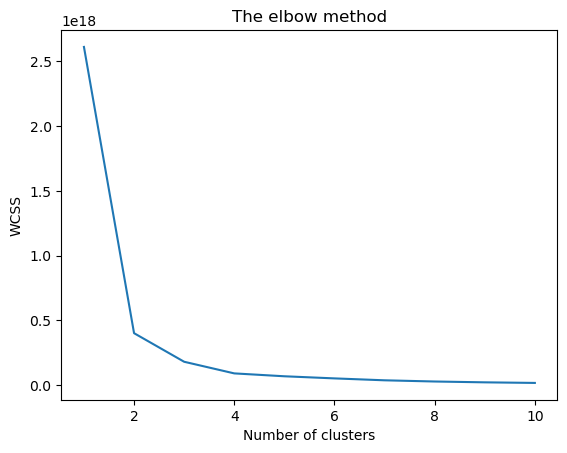

In [21]:
from sklearn.cluster import KMeans

wcss = []    

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(EUROSTAT_unsup)
    wcss.append(kmeans.inertia_)

    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')   
plt.show()

from the above, I can determine from the 'elbow' (where the line starts to decrease at a slower rate_ that 3 or 4 is the optimum number of neighbours.

Edit: From trying both, 4 is the optimum number of clusters.

In [22]:
kmeans = KMeans(n_clusters=4, random_state=0)
cluster_labels = kmeans.fit_predict(EUROSTAT_unsup)

### 2.2.2 Dimensionality Reduction (PCA)

Principal Component Analysis (PCA) - reduces dimensionality to principle components so I can visualise it easier.

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(EUROSTAT_unsup)
pca_df = pd.DataFrame(data=pca_result, columns=['pca1', 'pca2'])
pca_df['cluster'] = cluster_labels

### 2.2.3 Visualisation of clusters

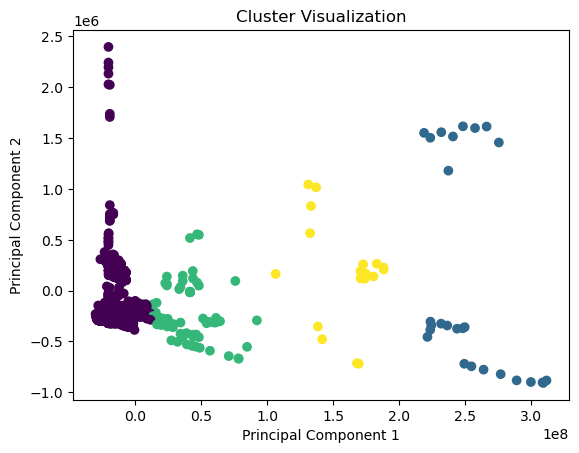

In [24]:
plt.scatter(pca_df['pca1'], pca_df['pca2'], c=pca_df['cluster'], cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Visualization')
plt.show()

### Conclusions

From the visualisation above, I can see that there are some very weak relationships among the features. This implies that my whole dataset in its entirety won't be very good at predicting. However, there are some features which could be useful. These are likely the datasets based on Rail data which I knew were correlated from the correlation matrix heatmap at the start of Section 2, but I hoped the ML would find a hidden relationship. Thus, it can be concluded that most of the supplementary datasets I added were not useful.